# PM2.5 forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pm25_hyperparameters import *

train=pd.read_csv("BeijingPM_train.csv").drop("date",axis=1)
#test=df[df.shape[0]-24:]
#train=df[:df.shape[0]-24]
test=pd.read_csv("BeijingPM_test.csv").drop("date",axis=1)

train.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2010,1,3,0,4,63.0,-7.0,92.0,1027.0,-6.0,...,0.4,58.56,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
1,2010,1,3,1,4,65.0,-8.0,85.0,1026.0,-6.0,...,0.5,61.69,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
2,2010,1,3,2,4,55.0,-8.0,92.0,1026.0,-7.0,...,0.5,65.71,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,55.0
3,2010,1,3,3,4,65.0,-8.0,92.0,1025.0,-7.0,...,0.7,68.84,181.0,-12.0,-20.0,25.0,1014.0,0.0,0.89,55.0
4,2010,1,3,4,4,83.0,-8.0,92.0,1024.0,-7.0,...,1.2,72.86,181.0,-10.0,-20.0,25.0,1014.0,0.0,0.89,55.0


In [2]:
test.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2015,10,1,0,3,38.0,14.0,93.0,1011.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,10,1,1,3,34.0,14.0,93.0,1010.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,10,1,2,3,2.0,12.0,82.0,1010.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,10,1,3,3,1.0,7.0,58.0,1010.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,10,1,4,3,1.4,6.0,54.0,1010.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Training set for meteorological prediction model

In [3]:
x_met=["year","month","day","hour","season"]
y_met=list(set(prim_fea)-set(["PM"]))

# Column names for lagged features
for col in y_met:
    for t in range(1,lag_hours+1):
        x_met.append("%s_lag%d" % (col,t))
    for r in ["mean","max","min"]:
        x_met.append("%s_%s" % (col,r))

met_xtrain=train[x_met]
met_ytrain=train[y_met]

met_ytest=test[y_met]

## Prepare the testing set

In [4]:
def fill_fea(pos):
    for col in y_met:
        lagtmp=[]
        for t in range(1,lag_hours+1):
            if t<=pos:
                x=test.loc[pos-t,col]
            else:
                x=train.loc[train.shape[0]+pos-t,col]
            test.loc[pos,"%s_lag%d" % (col,t)]=x
            lagtmp.append(x)
        test.loc[pos,"%s_mean" % col]=np.mean(lagtmp)
        test.loc[pos,"%s_min" % col]=np.min(lagtmp)
        test.loc[pos,"%s_max" % col]=np.max(lagtmp)

test.loc[[0]]

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2015,10,1,0,3,38.0,14.0,93.0,1011.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Predict meteorological parameters

In this section, we predict meteorological parameters for the testing set using primitive datetime features

In [5]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

met_model=MultiOutputRegressor(LGBMRegressor(random_state=101,eval_metric="rmse"),n_jobs=4)
met_model.fit(met_xtrain,met_ytrain)

MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             eval_metric='rmse',
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=101, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsample=1.0,
                          

In [6]:
for k in tqdm(range(24)):
    fill_fea(k)
    test.loc[k,y_met]=pd.DataFrame(met_model.predict(test.loc[[k],x_met]),columns=y_met).loc[0]

100%|██████████| 24/24 [00:04<00:00,  4.92it/s]


In [7]:
mae=abs(test.loc[range(24),y_met]-met_ytest.loc[range(24)]).mean()
mae.index=["MAE of %s" % c for c in mae.index]
mae

MAE of TEMP              2.753388
MAE of DEWP             10.000572
MAE of Iws              58.612340
MAE of PRES              2.076904
MAE of precipitation     0.578834
MAE of HUMI             44.192185
dtype: float64

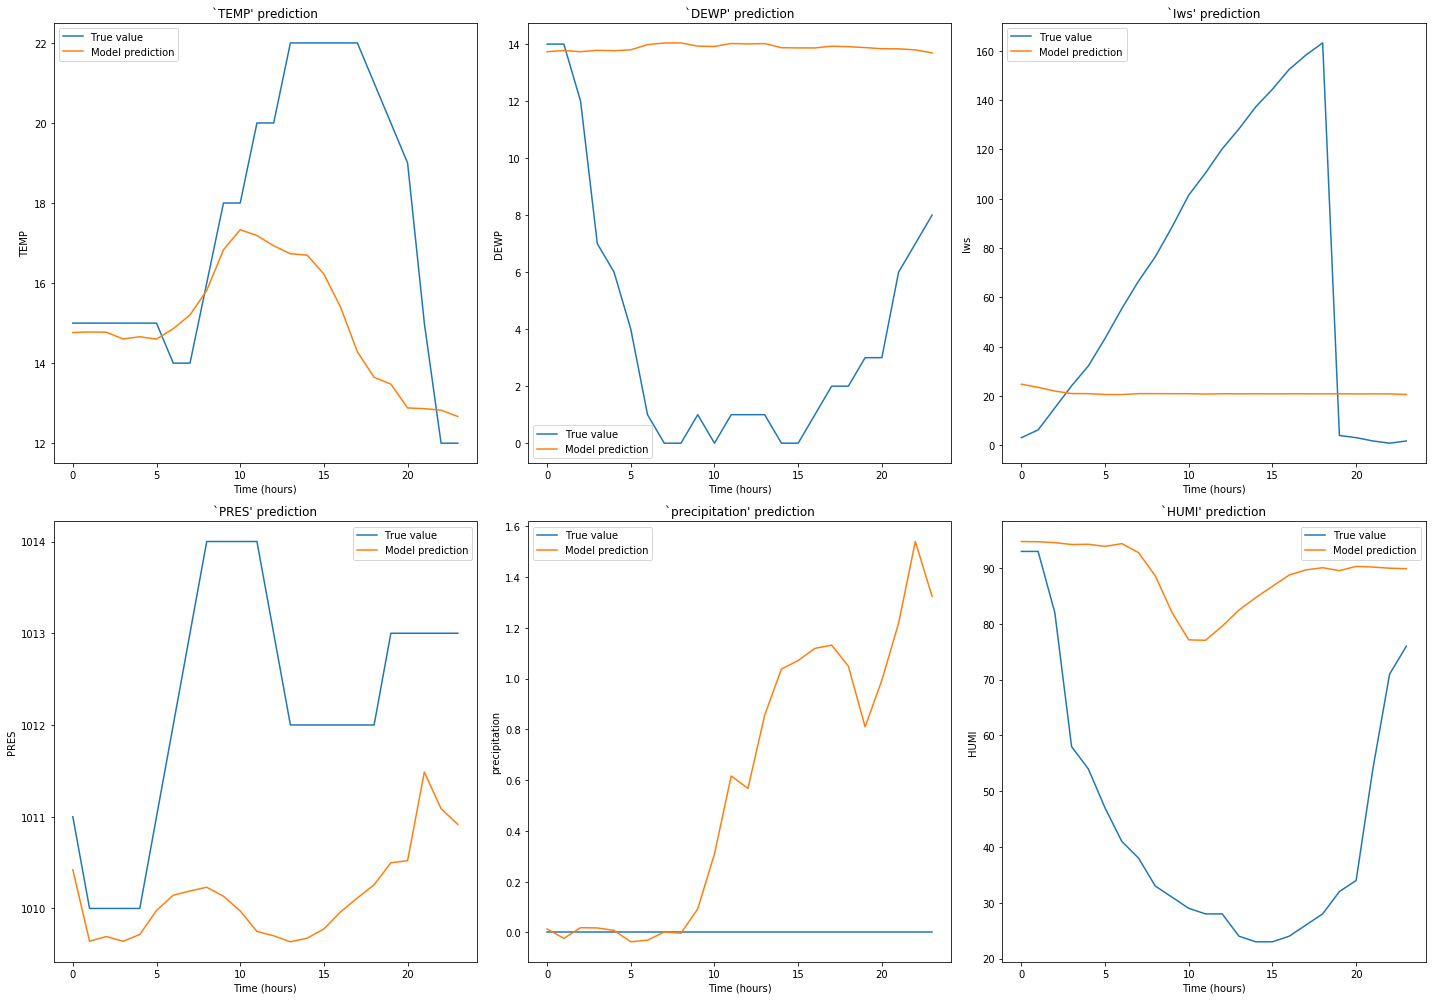

In [8]:
f=plt.figure(figsize=(20,14))
f.set_tight_layout(True)

for i,c in enumerate(y_met):
    ax=plt.subplot(2,3,i+1)
    ax.set_title("`%s' prediction" % c)
    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("%s" % c)
    ax.plot(range(24),met_ytest.loc[range(24),c],label="True value")
    ax.plot(range(24),test.loc[range(24),c],label="Model prediction")
    ax.legend()

plt.savefig("graphs/met_prediction.png")